<a href="https://colab.research.google.com/github/aarsanjani/meansquares/blob/master/version2/modeling/clustering/CA_FractalClustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Goal**

* Apply GMM clustering for combined dataset and Maryland university dataset

# Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


# Import packages

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
import numpy as np
import seaborn as sns


# Clustering Combined dataset

## Load data

In [3]:
CA_combined_data = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/projectdata-2021/CA_alldatasets_Jan13.csv',low_memory=False)
CA_combined_data.head()

,Date,Province_State,FIPS,New cases,County Name,population,mask_rule_active,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,2020-03-01,California,6001,0,Alameda County,1671329,0,3.684,58,6.0,9.0,15.0,1.0,4.0,0.0
1,2020-03-02,California,6001,0,Alameda County,1671329,0,6.182,98,4.0,7.0,7.0,-1.0,3.0,0.0
2,2020-03-03,California,6001,1,Alameda County,1671329,0,6.271,100,5.0,12.0,41.0,0.0,1.0,-1.0
3,2020-03-04,California,6001,0,Alameda County,1671329,0,6.209,99,1.0,6.0,23.0,-3.0,1.0,0.0
4,2020-03-05,California,6001,0,Alameda County,1671329,0,6.654,106,1.0,6.0,12.0,-5.0,-1.0,1.0


In [6]:
CA_combined_data['New cases/100k'] = CA_combined_data['New cases'] * 100000 / CA_combined_data['population']
CA_combined_data.head()

,Date,Province_State,FIPS,New cases,County Name,population,mask_rule_active,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,New cases/100k
0,2020-03-01,California,6001,0,Alameda County,1671329,0,3.684,58,6.0,9.0,15.0,1.0,4.0,0.0,0.000000
1,2020-03-02,California,6001,0,Alameda County,1671329,0,6.182,98,4.0,7.0,7.0,-1.0,3.0,0.0,0.000000
2,2020-03-03,California,6001,1,Alameda County,1671329,0,6.271,100,5.0,12.0,41.0,0.0,1.0,-1.0,0.059833
3,2020-03-04,California,6001,0,Alameda County,1671329,0,6.209,99,1.0,6.0,23.0,-3.0,1.0,0.0,0.000000
4,2020-03-05,California,6001,0,Alameda County,1671329,0,6.654,106,1.0,6.0,12.0,-5.0,-1.0,1.0,0.000000


## Prepare data for training

In [7]:
CA_combined_data.columns

Index(['Date', 'Province_State', 'FIPS', 'New cases', 'County Name',
       'population', 'mask_rule_active', 'm50', 'm50_index',
       'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline', 'New cases/100k'],
      dtype='object')

In [8]:
print(CA_combined_data.shape)
CA_combined_data = CA_combined_data.dropna()
print(CA_combined_data.shape)


(10478, 16)
(10478, 16)


In [22]:
CA_combined_data.describe()

,FIPS,New cases,population,mask_rule_active,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,New cases/100k
count,10478.000000,10478.000000,1.047800e+04,10478.000000,10478.000000,10478.000000,10478.000000,10478.000000,10478.000000,10478.000000,10478.000000,10478.000000,10478.000000
mean,6061.821531,201.224661,1.091493e+06,0.625310,2.357829,37.255010,-28.745467,-6.832506,5.529299,-31.339091,-33.201661,11.584272,16.319304
std,30.300875,805.851678,1.757733e+06,0.484066,1.601423,23.753632,15.968854,11.844379,40.737068,25.174504,16.401085,6.811364,29.244746
min,6001.000000,-621.000000,2.839300e+04,0.000000,0.019000,0.000000,-87.000000,-74.000000,-80.000000,-88.000000,-87.000000,-4.000000,-75.521990
25%,6037.000000,2.000000,2.191860e+05,0.000000,1.164000,19.000000,-38.000000,-14.000000,-19.000000,-49.000000,-42.000000,7.000000,0.598520
50%,6065.000000,30.000000,4.661950e+05,1.000000,2.202500,37.000000,-27.000000,-7.000000,0.000000,-33.000000,-34.000000,11.000000,5.763755
75%,6085.000000,126.000000,1.153526e+06,1.000000,3.245000,52.000000,-19.000000,0.000000,22.000000,-18.000000,-21.000000,15.000000,17.796696
max,6115.000000,28408.000000,1.003911e+07,1.000000,10.324000,159.000000,23.000000,51.000000,323.000000,97.000000,11.000000,37.000000,401.464627


**Note:** From the above describe value, the threashold are defined as value greater than mean

In [33]:
retail_threshold = np.std(CA_combined_data['retail_and_recreation_percent_change_from_baseline'].values)
newcases_threshold = np.std(CA_combined_data['New cases/100k'].values)
m50_threshold = np.std(CA_combined_data['m50'].values)
print('retail_threshold: ', retail_threshold)
print('newcases_threshold: ', newcases_threshold)
print('m50_threshold: ', m50_threshold)

retail_threshold:  15.968092348356633
newcases_threshold:  29.243350731306947
m50_threshold:  1.6013464274046014


In [9]:
cols = [ 'population', 'mask_rule_active', 'm50', 'm50_index',
       'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline', 'New cases/100k']

In [10]:
training_inputs = CA_combined_data[cols]

In [11]:
gmm = GaussianMixture(n_components=7)
gmm.fit(training_inputs)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=7, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [12]:
labels = gmm.predict(training_inputs)
output_frame = CA_combined_data.copy() 
# Add a column for the current dataframe and save it as 'output_frame'
output_frame['cluster'] = labels

In [13]:
output_frame.head()

,Date,Province_State,FIPS,New cases,County Name,population,mask_rule_active,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,New cases/100k,cluster
0,2020-03-01,California,6001,0,Alameda County,1671329,0,3.684,58,6.0,9.0,15.0,1.0,4.0,0.0,0.000000,3
1,2020-03-02,California,6001,0,Alameda County,1671329,0,6.182,98,4.0,7.0,7.0,-1.0,3.0,0.0,0.000000,3
2,2020-03-03,California,6001,1,Alameda County,1671329,0,6.271,100,5.0,12.0,41.0,0.0,1.0,-1.0,0.059833,3
3,2020-03-04,California,6001,0,Alameda County,1671329,0,6.209,99,1.0,6.0,23.0,-3.0,1.0,0.0,0.000000,3
4,2020-03-05,California,6001,0,Alameda County,1671329,0,6.654,106,1.0,6.0,12.0,-5.0,-1.0,1.0,0.000000,3


## Defining Threshold method

In [19]:
def max_values(df, cluster= 0):
  data = df[df['cluster'] == cluster]
  return max(data['retail_and_recreation_percent_change_from_baseline'].values),max(data['New cases/100k'].values),max(data['m50'].values)


## Iteration 1

In [36]:
print('input shape :',output_frame.shape)
df_iter1 = pd.DataFrame(columns = output_frame.columns) 

for k in range(0,6):

    data = output_frame[output_frame["cluster"]==k]
    print(k, data.shape)
    print(max_values(data,k))

    retail_value, newcases_value, m50_value = max_values(data,k)
    print('values ',retail_value, newcases_value, m50_value)
    print('threshold ', retail_threshold,newcases_threshold, m50_threshold )

    if retail_value > retail_threshold and newcases_value > newcases_threshold and m50_value > m50_threshold:
       print(" condition satisfied !")
       df_iter1 = pd.concat([df_iter1,data])
       print('concate shape : ',df_iter1.shape)


print('output shape : ',df_iter1.shape)
df_iter1.head()

  

input shape : (10478, 17)
0 (3153, 17)
(23.0, 35.59465317459813, 10.324000000000002)
values  23.0 35.59465317459813 10.324000000000002
threshold  15.968092348356633 29.243350731306947 1.6013464274046014
 condition satisfied !
concate shape :  (3153, 17)
1 (300, 17)
(8.0, 282.97337601840485, 7.351)
values  8.0 282.97337601840485 7.351
threshold  15.968092348356633 29.243350731306947 1.6013464274046014
2 (598, 17)
(11.0, 300.0800427506267, 9.524)
values  11.0 300.0800427506267 9.524
threshold  15.968092348356633 29.243350731306947 1.6013464274046014
3 (3646, 17)
(18.0, 401.46462665097425, 8.516)
values  18.0 401.46462665097425 8.516
threshold  15.968092348356633 29.243350731306947 1.6013464274046014
 condition satisfied !
concate shape :  (6799, 17)
4 (600, 17)
(7.0, 266.7501415378348, 8.71)
values  7.0 266.7501415378348 8.71
threshold  15.968092348356633 29.243350731306947 1.6013464274046014
5 (775, 17)
(-19.0, 54.62718591013499, 4.647)
values  -19.0 54.62718591013499 4.647
threshold  1

,Date,Province_State,FIPS,New cases,County Name,population,mask_rule_active,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,New cases/100k,cluster
575,2020-03-01,California,6007,0,Butte County,219186,0,2.660,57,14.0,12.0,34.0,-8.0,5.0,-1.0,0.0,0
576,2020-03-02,California,6007,0,Butte County,219186,0,4.618,100,8.0,13.0,16.0,-4.0,8.0,-1.0,0.0,0
577,2020-03-03,California,6007,0,Butte County,219186,0,4.326,93,13.0,14.0,31.0,5.0,4.0,-2.0,0.0,0
578,2020-03-04,California,6007,0,Butte County,219186,0,4.687,101,9.0,10.0,40.0,-14.0,3.0,-1.0,0.0,0
579,2020-03-05,California,6007,0,Butte County,219186,0,4.561,98,8.0,11.0,29.0,-4.0,2.0,-2.0,0.0,0


## Iteration: 2

In [39]:
training_inputs = df_iter1[cols]
gmm = GaussianMixture(n_components=7)
gmm.fit(training_inputs)
labels = gmm.predict(training_inputs)
output_frame = df_iter1.copy() 
# Add a column for the current dataframe and save it as 'output_frame'
output_frame['cluster'] = labels

print('input shape :',output_frame.shape)
df_iter2 = pd.DataFrame(columns = output_frame.columns) 

for k in range(0,6):

    data = output_frame[output_frame["cluster"]==k]
    print(k, data.shape)
    print(max_values(data,k))

    retail_value, newcases_value, m50_value = max_values(data,k)
    # print('values ',retail_value, newcases_value, m50_value)
    # print('threshold ', retail_threshold,newcases_threshold, m50_threshold )

    if retail_value > retail_threshold and newcases_value > newcases_threshold and m50_value > m50_threshold:
       df_iter2 = pd.concat([df_iter2,data])


print('output shape : ',df_iter2.shape)
df_iter2.head()

  

input shape : (6799, 17)
0 (90, 17)
(-6.0, 258.2567668239384, 3.786)
1 (481, 17)
(-9.0, 78.87090494354425, 5.391)
2 (642, 17)
(-11.0, 49.96262586863873, 5.308)
3 (2513, 17)
(23.0, 18.237927541632335, 10.324000000000002)
4 (1060, 17)
(12.0, 401.46462665097425, 5.836)
5 (1440, 17)
(19.0, 90.89348935656308, 9.052999999999999)
output shape :  (1440, 17)


,Date,Province_State,FIPS,New cases,County Name,population,mask_rule_active,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,New cases/100k,cluster
2125,2020-06-18,California,6017,4,El Dorado County,192843,1,5.969,61,-13.0,14.0,209.0,-18.0,-37.0,10.0,2.074226,5
2126,2020-06-19,California,6017,5,El Dorado County,192843,1,7.336,75,-18.0,11.0,195.0,-16.0,-38.0,8.0,2.592783,5
2127,2020-06-20,California,6017,0,El Dorado County,192843,1,6.159,63,-23.0,14.0,138.0,-14.0,-17.0,4.0,0.000000,5
2128,2020-06-21,California,6017,0,El Dorado County,192843,1,6.059,62,-11.0,20.0,204.0,-15.0,-21.0,1.0,0.000000,5
2129,2020-06-22,California,6017,15,El Dorado County,192843,1,5.294,54,-12.0,13.0,183.0,-11.0,-39.0,9.0,7.778348,5


## Iteration 3

In [40]:
training_inputs = df_iter2[cols]
gmm = GaussianMixture(n_components=7)
gmm.fit(training_inputs)
labels = gmm.predict(training_inputs)
output_frame = df_iter2.copy() 
# Add a column for the current dataframe and save it as 'output_frame'
output_frame['cluster'] = labels

print('input shape :',output_frame.shape)
df_iter3 = pd.DataFrame(columns = output_frame.columns) 

for k in range(0,6):

    data = output_frame[output_frame["cluster"]==k]
    print(k, data.shape)
    print(max_values(data,k))

    retail_value, newcases_value, m50_value = max_values(data,k)
    # print('values ',retail_value, newcases_value, m50_value)
    # print('threshold ', retail_threshold,newcases_threshold, m50_threshold )

    if retail_value > retail_threshold and newcases_value > newcases_threshold and m50_value > m50_threshold:
       df_iter3 = pd.concat([df_iter3,data])


print('output shape : ',df_iter3.shape)
df_iter3.head()

  

input shape : (1440, 17)
0 (294, 17)
(7.0, 80.08338841714547, 8.581)
1 (237, 17)
(-1.0, 88.2929117346798, 6.5089999999999995)
2 (235, 17)
(-12.0, 64.91686215494475, 4.5169999999999995)
3 (131, 17)
(-17.0, 51.24716553287982, 4.4910000000000005)
4 (148, 17)
(19.0, 66.60695009072326, 9.052999999999999)
5 (258, 17)
(-2.0, 90.89348935656308, 6.569)
output shape :  (148, 17)


,Date,Province_State,FIPS,New cases,County Name,population,mask_rule_active,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,New cases/100k,cluster
4475,2020-06-18,California,6033,0,Lake County,64386,1,1.638,51,-8.0,2.0,71.0,-23.0,-26.0,6.0,0.000000,4
4476,2020-06-19,California,6033,0,Lake County,64386,1,2.083,66,-8.0,9.0,52.0,-5.0,-26.0,5.0,0.000000,4
4479,2020-06-22,California,6033,5,Lake County,64386,1,1.914,60,-3.0,7.0,53.0,-19.0,-26.0,5.0,7.765663,4
4481,2020-06-24,California,6033,0,Lake County,64386,1,1.669,52,-5.0,10.0,53.0,-7.0,-26.0,6.0,0.000000,4
4482,2020-06-25,California,6033,1,Lake County,64386,1,2.005,63,-10.0,6.0,74.0,-19.0,-27.0,6.0,1.553133,4


In [41]:
df_iter3['County Name'].unique()

array(['Lake County', 'Mendocino County', 'Siskiyou County',
       'Tehama County', 'San Benito County'], dtype=object)

In [51]:
df_iter3.describe()

,m50,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,New cases/100k
count,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000
mean,2.061101,-7.547297,5.972973,38.743243,2.344595,-18.594595,5.047297,13.327747
std,1.571197,9.900412,7.762588,33.572365,24.900814,9.631890,2.703826,15.841498
min,0.189000,-29.000000,-12.000000,-33.000000,-57.000000,-35.000000,-4.000000,0.000000
25%,0.956250,-14.250000,0.000000,14.000000,-18.250000,-26.000000,4.000000,1.553133
50%,1.537500,-8.000000,5.000000,35.000000,-0.500000,-20.500000,6.000000,7.765663
75%,2.877750,-1.000000,11.000000,65.000000,16.250000,-15.000000,7.000000,18.437711
max,9.053000,19.000000,29.000000,131.000000,64.000000,5.000000,11.000000,66.606950


## Iteration 4:

In [42]:
training_inputs = df_iter3[cols]
gmm = GaussianMixture(n_components=7)
gmm.fit(training_inputs)
labels = gmm.predict(training_inputs)
output_frame = df_iter3.copy() 
# Add a column for the current dataframe and save it as 'output_frame'
output_frame['cluster'] = labels

print('input shape :',output_frame.shape)
df_iter4 = pd.DataFrame(columns = output_frame.columns) 

for k in range(0,6):

    data = output_frame[output_frame["cluster"]==k]
    print(k, data.shape)
    print(max_values(data,k))

    retail_value, newcases_value, m50_value = max_values(data,k)
    # print('values ',retail_value, newcases_value, m50_value)
    # print('threshold ', retail_threshold,newcases_threshold, m50_threshold )

    if retail_value > retail_threshold and newcases_value > newcases_threshold and m50_value > m50_threshold:
       df_iter4 = pd.concat([df_iter4,data])


print('output shape : ',df_iter4.shape)
df_iter4.head()

  

input shape : (148, 17)
0 (13, 17)
(-5.0, 59.92256161268514, 4.033)
1 (18, 17)
(1.0, 66.60695009072326, 3.2510000000000003)
2 (1, 17)
(-3.0, 4.611004161431255, 2.121)
3 (80, 17)
(6.0, 60.572174075109494, 3.364)
4 (2, 17)
(-15.0, 27.066615717742962, 1.929)
5 (25, 17)
(-11.0, 43.02132628603036, 9.052999999999999)
output shape :  (0, 17)


,Date,Province_State,FIPS,New cases,County Name,population,mask_rule_active,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,New cases/100k,cluster


In [44]:
df_iter4_cluster5 = output_frame[output_frame['cluster'] == 5]
print(df_iter4_cluster5.shape)
df_iter4_cluster5

(25, 17)


,Date,Province_State,FIPS,New cases,County Name,population,mask_rule_active,m50,m50_index,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,New cases/100k,cluster
14139,2020-06-19,California,6103,2,Tehama County,65084,1,9.053,142,-22.0,14.0,32.0,7.0,-29.0,5.0,3.072952,5
14140,2020-06-20,California,6103,0,Tehama County,65084,1,7.109,111,-18.0,23.0,7.0,-5.0,-5.0,1.0,0.000000,5
14146,2020-06-26,California,6103,0,Tehama County,65084,1,6.072,95,-21.0,7.0,29.0,2.0,-28.0,6.0,0.000000,5
14147,2020-06-27,California,6103,0,Tehama County,65084,1,5.404,84,-16.0,13.0,29.0,-1.0,-5.0,1.0,0.000000,5
14160,2020-07-10,California,6103,0,Tehama County,65084,1,6.192,97,-20.0,12.0,34.0,10.0,-29.0,6.0,0.000000,5
14161,2020-07-11,California,6103,6,Tehama County,65084,1,3.578,56,-21.0,17.0,20.0,-3.0,-1.0,1.0,9.218856,5
14168,2020-07-18,California,6103,0,Tehama County,65084,1,1.402,22,-26.0,15.0,33.0,3.0,-9.0,2.0,0.000000,5
14181,2020-07-31,California,6103,0,Tehama County,65084,1,5.624,88,-23.0,6.0,37.0,16.0,-31.0,6.0,0.000000,5
14182,2020-08-01,California,6103,7,Tehama County,65084,1,3.730,58,-19.0,19.0,36.0,7.0,-8.0,1.0,10.755332,5
14189,2020-08-08,California,6103,5,Tehama County,65084,1,4.493,70,-22.0,13.0,59.0,6.0,-10.0,1.0,7.682380,5


In [45]:
df_iter4_cluster5['County Name'].unique()

array(['Tehama County'], dtype=object)

## Visualize iteration3 result and cluster 5 of iteration 4 (which has maximum cases)

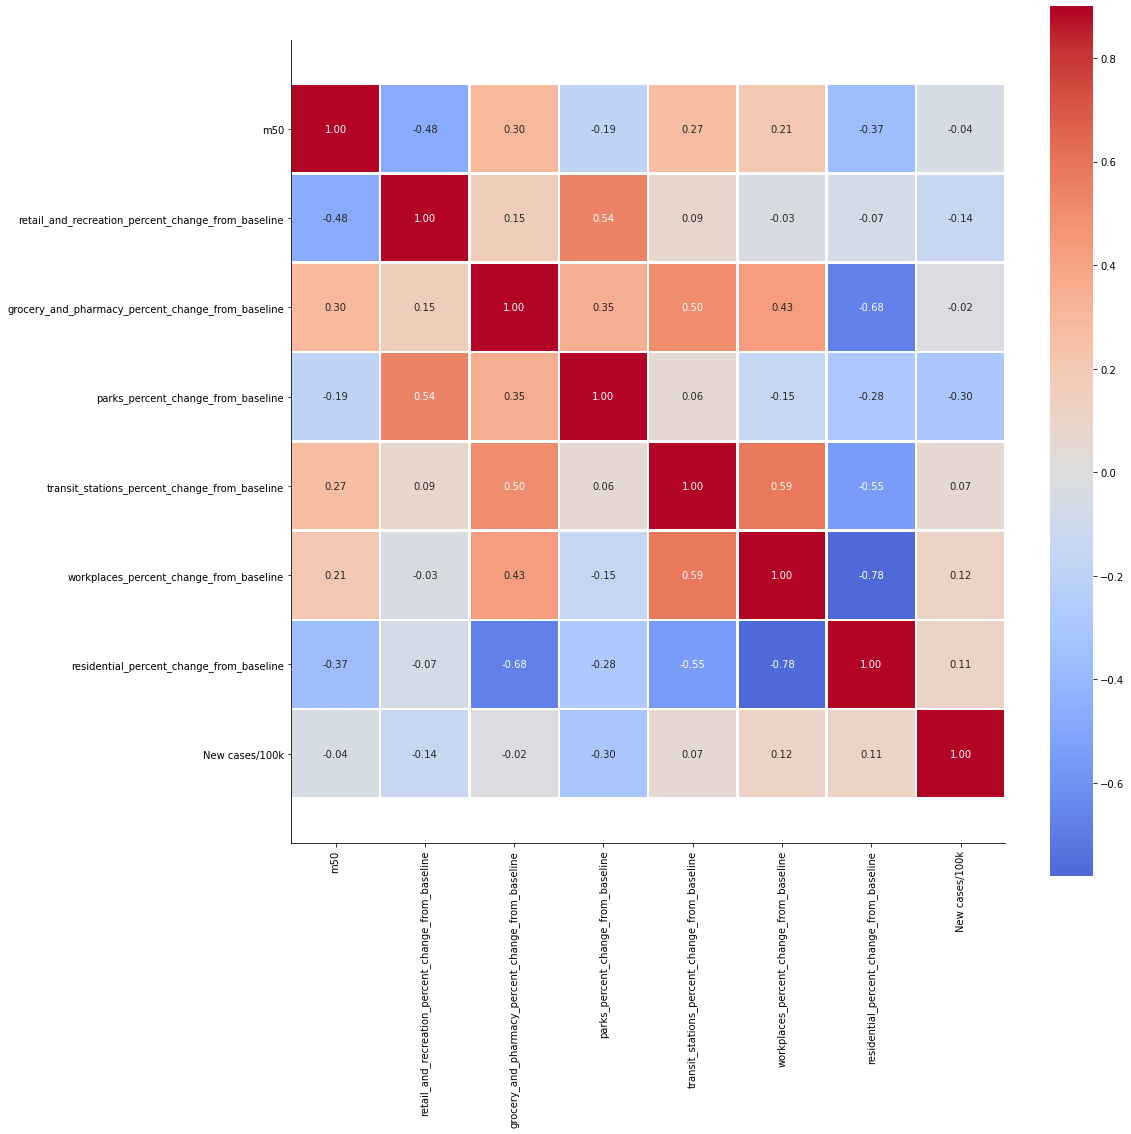

In [50]:
corr = df_iter3.corr()
g = sns.heatmap(corr, vmax=.9, center=0,
               square=True, linewidths=1.5, cbar_kws={"shrink": .8}, annot=True, fmt='.2f', cmap='coolwarm')
bottom, top = g.get_ylim()
g.set_ylim(bottom + 0.5, top - 0.5)
sns.despine()
g.figure.set_size_inches(16, 20)

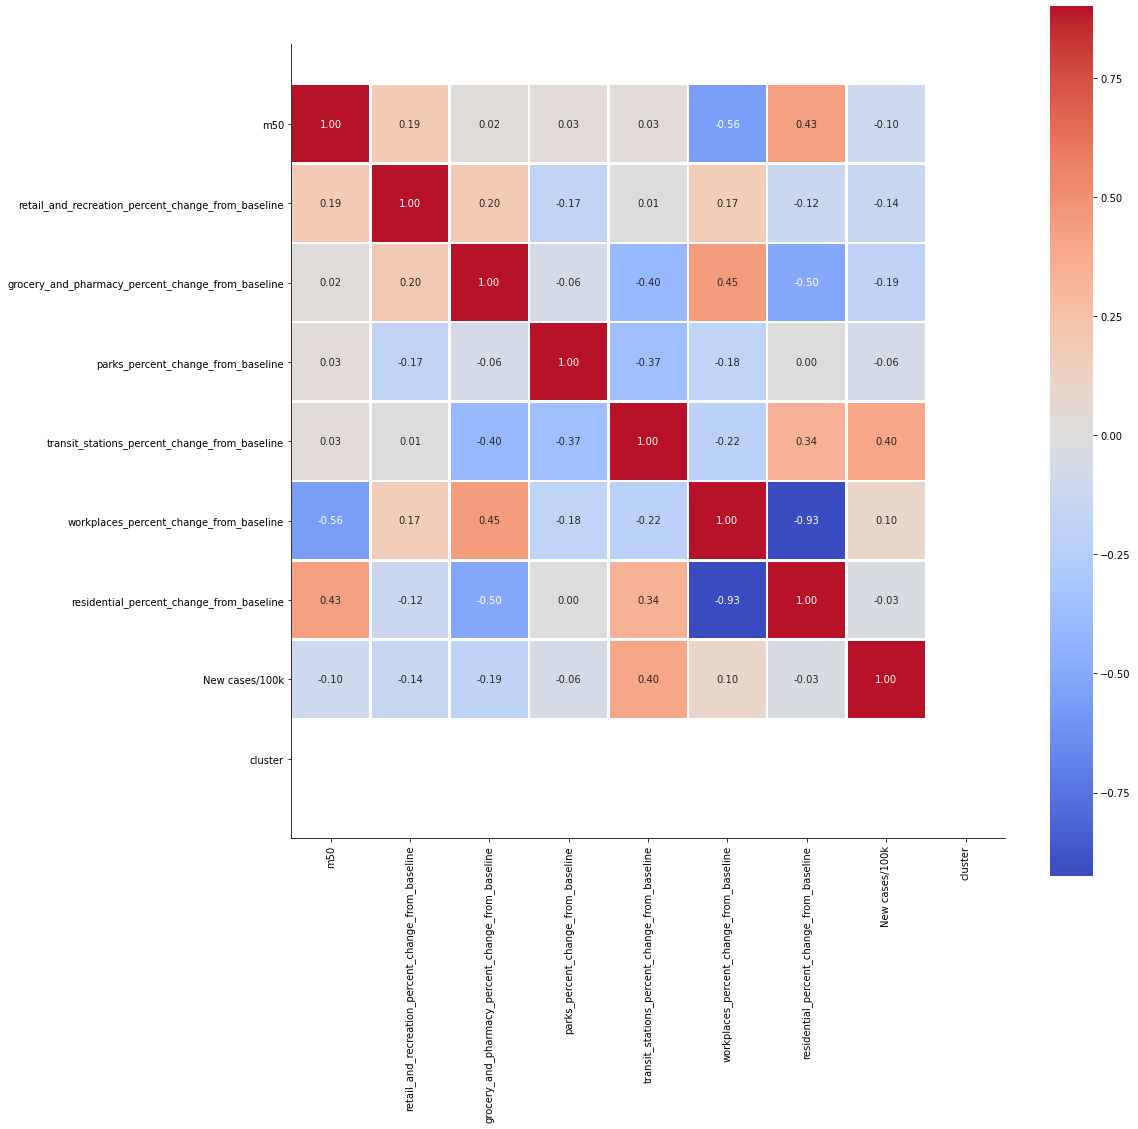

In [48]:
corr = df_iter4_cluster5.corr()
g = sns.heatmap(corr, vmax=.9, center=0,
               square=True, linewidths=1.5, cbar_kws={"shrink": .8}, annot=True, fmt='.2f', cmap='coolwarm')
bottom, top = g.get_ylim()
g.set_ylim(bottom + 0.5, top - 0.5)
sns.despine()
g.figure.set_size_inches(16, 20)

## Conclusion for combined dataset

After running the iteration for 4 levels, the data failed to meet threshold, hence I declared iteration 3 output as final -golden cluster

# Clustering Maryland inertia dataset

## Load data

In [113]:
CA_inertia_data = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/projectdata-2021/CA_processedMarylandData_Jan11.csv',low_memory=False)
CA_inertia_data.head()

,countyFIPS,County Name,State,population,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,date,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Population.density,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate
0,6001,Alameda County,CA,1671329,6001,Alameda County,6,50,32,2.41,26.1,0.4,38.0,0.20,2.21,0,1666753,-21.7,2020-01-01,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,NaN,0.0,0.0,0,54.0,0.0,0.0,0.0,0,0,0.0,0,0.9,3.9,5.7,0.3,0.0
1,6001,Alameda County,CA,1671329,6001,Alameda County,6,24,22,3.17,27.9,0.4,38.5,0.50,2.66,0,1666753,-5.8,2020-01-02,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,NaN,0.0,0.0,0,54.0,0.0,0.0,0.0,0,0,0.0,0,0.9,3.9,5.7,0.3,0.0
2,6001,Alameda County,CA,1671329,6001,Alameda County,6,21,21,3.28,27.2,0.4,41.0,0.51,2.78,0,1666753,-1.5,2020-01-03,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,NaN,0.0,0.0,0,54.0,0.0,0.0,0.0,0,0,0.0,0,0.9,3.9,5.7,0.3,0.0
3,6001,Alameda County,CA,1671329,6001,Alameda County,6,34,25,3.03,25.8,0.3,41.1,0.26,2.76,0,1666753,-2.2,2020-01-04,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,NaN,0.0,0.0,0,54.0,0.0,0.0,0.0,0,0,0.0,0,0.9,3.9,5.7,0.3,0.0
4,6001,Alameda County,CA,1671329,6001,Alameda County,6,44,29,2.72,24.5,0.4,35.8,0.24,2.48,0,1666753,-12.1,2020-01-05,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,NaN,0.0,0.0,0,54.0,0.0,0.0,0.0,0,0,0.0,0,1.3,3.9,5.7,0.3,0.0


In [114]:
CA_inertia_data['New cases/100k'] = CA_inertia_data['New.COVID.cases'] * 100000 / CA_inertia_data['population']
CA_inertia_data.head()

,countyFIPS,County Name,State,population,CTFIPS,CTNAME,STFIPS,Social.distancing.index,X..staying.home,Trips.person,X..out.of.county.trips,X..out.of.state.trips,Miles.person,Work.trips.person,Non.work.trips.person,New.COVID.cases,Population,X..change.in.consumption,date,Transit.mode.share,X..people.older.than.60,Median.income,X..African.Americans,X..Hispanic.Americans,X..Male,Population.density,Employment.density,X..hot.spots.1000.people,Hospital.beds.1000.people,ICUs.1000.people,X..contact.tracing.workers.1000.people,New.cases.1000.people,Active.cases.1000.people,X.days..decreasing.COVID.cases,X..hospital.bed.utilization,Testing.capacity,Tests.done.1000.people,X..ICU.utilization,Ventilator.shortage,Imported.COVID.cases,COVID.exposure.1000.people,X.days..decreasing.ILI.cases,Unemployment.claims.1000.people,Unemployment.rate,X..working.from.home,Cumulative.inflation.rate,COVID.death.rate,New cases/100k
0,6001,Alameda County,CA,1671329,6001,Alameda County,6,50,32,2.41,26.1,0.4,38.0,0.20,2.21,0,1666753,-21.7,2020-01-01,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,NaN,0.0,0.0,0,54.0,0.0,0.0,0.0,0,0,0.0,0,0.9,3.9,5.7,0.3,0.0,0.0
1,6001,Alameda County,CA,1671329,6001,Alameda County,6,24,22,3.17,27.9,0.4,38.5,0.50,2.66,0,1666753,-5.8,2020-01-02,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,NaN,0.0,0.0,0,54.0,0.0,0.0,0.0,0,0,0.0,0,0.9,3.9,5.7,0.3,0.0,0.0
2,6001,Alameda County,CA,1671329,6001,Alameda County,6,21,21,3.28,27.2,0.4,41.0,0.51,2.78,0,1666753,-1.5,2020-01-03,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,NaN,0.0,0.0,0,54.0,0.0,0.0,0.0,0,0,0.0,0,0.9,3.9,5.7,0.3,0.0,0.0
3,6001,Alameda County,CA,1671329,6001,Alameda County,6,34,25,3.03,25.8,0.3,41.1,0.26,2.76,0,1666753,-2.2,2020-01-04,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,NaN,0.0,0.0,0,54.0,0.0,0.0,0.0,0,0,0.0,0,0.9,3.9,5.7,0.3,0.0,0.0
4,6001,Alameda County,CA,1671329,6001,Alameda County,6,44,29,2.72,24.5,0.4,35.8,0.24,2.48,0,1666753,-12.1,2020-01-05,15.04,19,92574,10.5,22.5,49.11,2002,1155,131,2.05,0.22,NaN,0.0,0.0,0,54.0,0.0,0.0,0.0,0,0,0.0,0,1.3,3.9,5.7,0.3,0.0,0.0


## Prepare data for training 

In [55]:
CA_inertia_data.columns

Index(['countyFIPS', 'County Name', 'State', 'population', 'CTFIPS', 'CTNAME',
       'STFIPS', 'Social.distancing.index', 'X..staying.home', 'Trips.person',
       'X..out.of.county.trips', 'X..out.of.state.trips', 'Miles.person',
       'Work.trips.person', 'Non.work.trips.person', 'New.COVID.cases',
       'Population', 'X..change.in.consumption', 'date', 'Transit.mode.share',
       'X..people.older.than.60', 'Median.income', 'X..African.Americans',
       'X..Hispanic.Americans', 'X..Male', 'Population.density',
       'Employment.density', 'X..hot.spots.1000.people',
       'Hospital.beds.1000.people', 'ICUs.1000.people',
       'X..contact.tracing.workers.1000.people', 'New.cases.1000.people',
       'Active.cases.1000.people', 'X.days..decreasing.COVID.cases',
       'X..hospital.bed.utilization', 'Testing.capacity',
       'Tests.done.1000.people', 'X..ICU.utilization', 'Ventilator.shortage',
       'Imported.COVID.cases', 'COVID.exposure.1000.people',
       'X.days..decreasi

In [115]:
X_cols = [ 'Social.distancing.index','X..staying.home', 'Trips.person', 'X..out.of.county.trips',
       'X..out.of.state.trips', 'Miles.person', 'Work.trips.person',
       'Non.work.trips.person', 'X..change.in.consumption', 'Transit.mode.share',
       'X..people.older.than.60', 'Median.income', 'X..African.Americans',
       'X..Hispanic.Americans', 'X..Male', 'Population.density',
       'Employment.density', 'X..hot.spots.1000.people',
       'Hospital.beds.1000.people', 'ICUs.1000.people',
       'X..contact.tracing.workers.1000.people','X..hospital.bed.utilization', 'Testing.capacity',
       'Tests.done.1000.people', 'X..ICU.utilization', 'Ventilator.shortage',
       'Imported.COVID.cases', 'COVID.exposure.1000.people',
       'X.days..decreasing.ILI.cases', 'Unemployment.claims.1000.people',
       'Unemployment.rate', 'X..working.from.home','Cumulative.inflation.rate', 'COVID.death.rate']

min_XCols = ['Active.cases.1000.people','Median.income','X..staying.home','Trips.person','Miles.person','X..hot.spots.1000.people','Testing.capacity',
             'Tests.done.1000.people','Population.density','Transit.mode.share',
             'Non.work.trips.person','X..African.Americans','Ventilator.shortage','Employment.density',
             'Imported.COVID.cases','X.days..decreasing.ILI.cases','X..Hispanic.Americans',
             'COVID.exposure.1000.people','New cases/100k']

In [116]:
CA_inertia_data = CA_inertia_data[min_XCols]
CA_inertia_data

,Active.cases.1000.people,Median.income,X..staying.home,Trips.person,Miles.person,X..hot.spots.1000.people,Testing.capacity,Tests.done.1000.people,Population.density,Transit.mode.share,Non.work.trips.person,X..African.Americans,Ventilator.shortage,Employment.density,Imported.COVID.cases,X.days..decreasing.ILI.cases,X..Hispanic.Americans,COVID.exposure.1000.people,New cases/100k
0,0.00,92574,32,2.41,38.0,131,0.0,0.00,2002,15.04,2.21,10.5,0,1155,0,0,22.5,0.00,0.000000
1,0.00,92574,22,3.17,38.5,131,0.0,0.00,2002,15.04,2.66,10.5,0,1155,0,0,22.5,0.00,0.000000
2,0.00,92574,21,3.28,41.0,131,0.0,0.00,2002,15.04,2.78,10.5,0,1155,0,0,22.5,0.00,0.000000
3,0.00,92574,25,3.03,41.1,131,0.0,0.00,2002,15.04,2.76,10.5,0,1155,0,0,22.5,0.00,0.000000
4,0.00,92574,29,2.72,35.8,131,0.0,0.00,2002,15.04,2.48,10.5,0,1155,0,0,22.5,0.00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21049,22.51,52624,24,2.93,51.1,76,6.5,777.86,117,0.94,2.71,3.1,2549,27,1619,0,27.8,39.82,78.812224
21050,22.63,52624,37,1.78,37.5,76,6.6,785.37,117,0.94,1.56,3.1,2631,27,1430,0,27.8,39.75,94.066202
21051,23.86,52624,29,2.59,50.0,76,6.6,794.97,117,0.94,2.37,3.1,2717,27,1657,0,27.8,39.75,0.000000
21052,24.42,52624,32,2.45,38.2,76,6.7,804.58,117,0.94,2.23,3.1,2807,27,1552,0,27.8,39.75,0.000000


In [117]:
print('input shape : ',CA_inertia_data.shape)
CA_inertia_data = CA_inertia_data.dropna()
print('output shape : ',CA_inertia_data.shape)

input shape :  (21054, 19)
output shape :  (21054, 19)


In [107]:
CA_inertia_data.describe()

,Active.cases.1000.people,Median.income,X..staying.home,Trips.person,Miles.person,X..hot.spots.1000.people,Testing.capacity,Tests.done.1000.people,Population.density,Transit.mode.share,Miles.person,Non.work.trips.person,X..African.Americans,Ventilator.shortage,Employment.density,Imported.COVID.cases,X.days..decreasing.ILI.cases,X..Hispanic.Americans,COVID.exposure.1000.people,New cases/100k
count,21054.000000,21054.000000,21054.000000,21054.000000,21054.000000,21054.000000,21054.000000,21054.000000,21054.000000,21054.000000,21054.000000,21054.000000,21054.000000,21054.000000,21054.000000,21054.000000,21054.000000,21054.000000,21054.000000,21054.000000
mean,3.396309,64378.551724,25.901016,3.056968,40.946276,133.896552,5.947658,204.875455,402.603448,2.899655,40.946276,2.675379,2.968966,555.542700,212.637931,743.222238,102.994490,30.324138,7.712948,12.956224
std,4.446005,18609.229204,6.259124,0.763587,17.299577,42.717679,4.491711,228.491166,766.005856,5.490104,17.299577,0.742236,2.889360,525.738724,495.167594,2051.807411,86.316517,17.896989,9.964504,35.409319
min,0.000000,38497.000000,0.000000,0.000000,0.000000,66.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.200000,0.000000,1.000000,0.000000,0.000000,7.200000,0.000000,0.000000
25%,0.200000,50905.000000,22.000000,2.790000,31.700000,102.000000,5.000000,0.740000,23.000000,0.540000,31.700000,2.440000,1.000000,241.000000,14.000000,5.000000,21.000000,14.500000,0.080000,0.000000
50%,2.450000,59157.500000,25.000000,3.060000,38.900000,132.000000,5.700000,105.350000,107.000000,1.165000,38.900000,2.690000,1.850000,532.000000,33.000000,106.000000,91.000000,25.600000,2.660000,1.037113
75%,4.950000,76753.000000,29.000000,3.320000,46.800000,156.000000,6.300000,369.430000,326.000000,2.030000,46.800000,2.900000,3.100000,677.000000,110.000000,574.000000,182.000000,45.100000,13.800000,11.202887
max,24.950000,116178.000000,100.000000,77.420000,291.200000,293.000000,30.300000,812.210000,3751.000000,34.220000,291.200000,77.040000,13.600000,2902.000000,3076.000000,43222.000000,266.000000,83.800000,39.820000,1275.635365


In [135]:
new_cases_threshold = np.std(CA_inertia_data['New cases/100k'].values)
median_income_threshold = np.std(CA_inertia_data['Median.income'].values)
miles_threshold = np.std(CA_inertia_data['Miles.person'].values)

print('std : ',new_cases_threshold)

std :  35.40847856216798


In [136]:
new_cases_threshold = np.mean(CA_inertia_data['New cases/100k'].values)
print('mean : ',new_cases_threshold)

mean :  12.956224066356778


## Define Threshold

In [122]:
def max_inertia_values(df, cluster= 0):
  data = df[df['cluster'] == cluster]
  return max(data['New cases/100k'].values),max(data['Median.income'].values),max(data['Miles.person'].values)


## Iteration 1

In [137]:
training_inputs = CA_inertia_data[min_XCols]
gmm = GaussianMixture(n_components=7)
gmm.fit(training_inputs)

labels = gmm.predict(training_inputs)
output_frame = CA_inertia_data.copy() 
# Add a column for the current dataframe and save it as 'output_frame'
output_frame['cluster'] = labels

print('lables: ',output_frame['cluster'].unique())
print('input shape :',output_frame.shape)
df_iter1 = pd.DataFrame(columns = output_frame.columns) 

for k in range(0,6):

    data = output_frame[output_frame["cluster"]==k]
    print(k, data.shape)
    #print(data.columns)
    #print(max_inertia_values(data,k))

    newcases_value, median_income_value, miles_value = max_inertia_values(data,k)
    print('values ',newcases_value, median_income_value, miles_value)

    #if newcases_value > new_cases_threshold and median_income_value > median_income_threshold and miles_value > miles_threshold:
    if newcases_value > new_cases_threshold: 
       #print(" condition satisfied !")
       df_iter1 = pd.concat([df_iter1,data])
       #print('concate shape : ',df_iter1.shape)


print('output shape : ',df_iter1.shape)
df_iter1.head()

  

lables:  [1 3 4 0 5 2 6]
input shape : (21054, 20)
0 (7432, 20)
values  1275.635364537337 81977 287.5
1 (726, 20)
values  87.55762765642041 93712 50.8
2 (1452, 20)
values  112.18761944394076 116178 113.7
3 (1825, 20)
values  708.5916740478299 65923 291.2
4 (5298, 20)
values  17.531014426993636 80582 127.7
5 (2173, 20)
values  154.43892497770986 85398 80.9
output shape :  (18906, 20)


,Active.cases.1000.people,Median.income,X..staying.home,Trips.person,Miles.person,X..hot.spots.1000.people,Testing.capacity,Tests.done.1000.people,Population.density,Transit.mode.share,Non.work.trips.person,X..African.Americans,Ventilator.shortage,Employment.density,Imported.COVID.cases,X.days..decreasing.ILI.cases,X..Hispanic.Americans,COVID.exposure.1000.people,New cases/100k,cluster
877,1.47,61198,30,2.17,30.9,147,5.7,49.17,63,0.16,2.01,2.0,714,20,43,70,13.6,0.90,22.64037,0
884,1.64,61198,24,2.37,55.4,147,5.5,59.72,63,0.16,2.31,2.0,685,20,56,77,13.6,1.16,0.00000,0
885,1.65,61198,22,2.90,65.5,147,5.4,61.46,63,0.16,2.62,2.0,570,20,46,77,13.6,1.20,0.00000,0
886,1.70,61198,20,3.15,98.1,147,5.4,62.85,63,0.16,2.85,2.0,569,20,51,84,13.6,1.25,0.00000,0
887,1.73,61198,16,3.23,53.1,147,5.4,64.23,63,0.16,2.90,2.0,569,20,48,84,13.6,1.30,0.00000,0


## Iteration 2

In [138]:
training_inputs = df_iter1[min_XCols]
gmm = GaussianMixture(n_components=7)
gmm.fit(training_inputs)

labels = gmm.predict(training_inputs)
output_frame = df_iter1.copy() 
# Add a column for the current dataframe and save it as 'output_frame'
output_frame['cluster'] = labels

print('lables: ',output_frame['cluster'].unique())
print('input shape :',output_frame.shape)
df_iter2 = pd.DataFrame(columns = output_frame.columns) 

for k in range(0,6):

    data = output_frame[output_frame["cluster"]==k]
    print(k, data.shape)
    #print(data.columns)
    #print(max_inertia_values(data,k))

    newcases_value, median_income_value, miles_value = max_inertia_values(data,k)
    print('values ',newcases_value, median_income_value, miles_value)

    #if newcases_value > new_cases_threshold and median_income_value > median_income_threshold and miles_value > miles_threshold:
    if newcases_value > new_cases_threshold:
       #print(" condition satisfied !")
       df_iter2 = pd.concat([df_iter2,data])
       #print('concate shape : ',df_iter1.shape)


print('output shape : ',df_iter1.shape)
df_iter2.head()

  

lables:  [3 1 4 5 2 6 0]
input shape : (18906, 20)
0 (1452, 20)
values  112.18761944394076 116178 113.7
1 (4131, 20)
values  291.91843942278507 56704 287.5
2 (2904, 20)
values  175.13692523245447 93712 95.5
3 (2211, 20)
values  708.5916740478299 77609 291.2
4 (4218, 20)
values  401.46462665097425 53865 104.6
5 (2175, 20)
values  1275.635364537337 58151 148.5
output shape :  (18906, 20)


,Active.cases.1000.people,Median.income,X..staying.home,Trips.person,Miles.person,X..hot.spots.1000.people,Testing.capacity,Tests.done.1000.people,Population.density,Transit.mode.share,Non.work.trips.person,X..African.Americans,Ventilator.shortage,Employment.density,Imported.COVID.cases,X.days..decreasing.ILI.cases,X..Hispanic.Americans,COVID.exposure.1000.people,New cases/100k,cluster
7260,0.0,110217,30,2.42,43.1,218,0.0,0.0,314,9.51,2.23,2.2,0,308,0,0,15.9,0.0,0.0,0
7261,0.0,110217,22,3.10,47.1,218,0.0,0.0,314,9.51,2.67,2.2,0,308,0,0,15.9,0.0,0.0,0
7262,0.0,110217,20,3.27,45.1,218,0.0,0.0,314,9.51,2.82,2.2,0,308,0,0,15.9,0.0,0.0,0
7263,0.0,110217,25,3.07,49.2,218,0.0,0.0,314,9.51,2.75,2.2,0,308,0,0,15.9,0.0,0.0,0
7264,0.0,110217,30,2.67,46.2,218,0.0,0.0,314,9.51,2.41,2.2,0,308,0,0,15.9,0.0,0.0,0


# conclusion:

After two iteration, I couldn't resolve the fractal clustering.